In [53]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from __future__ import print_function
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from lime.lime_tabular import RecurrentTabularExplainer
from tqdm import tqdm
import keras
from sp_modif.model_function import *
from sp_modif.methods import *
from sp_modif.data_prep import *
from sp_modif.evaluator import *
from sp_modif.SHAP import *
from sp_modif.L2X import *
import warnings

warnings.filterwarnings('ignore')
print("okay")

SEED = 0
def set_seed(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

# Appeler la fonction pour fixer le seed
set_seed(SEED)

okay


#### Function for explanation's generation

In [54]:
# Function to generate explanations
# Function explanation for lime

def get_lime_explanation(data, e, L2X=False) :
    # e  = fn = model.predict
    # Iniatialisation
    df_expplanation = pd.DataFrame(columns=[str(i) for i in range(data.shape[1]*data.shape[2])])

    # Get explanations
    for row in range(data.shape[0]) : 
        explanation = lime_explainer.explain_instance(data[row],
                                                      e,
                                                      num_features=data.shape[1]*data.shape[2]) 
        # fn = model.predict, initialize lime_explainer = Reccurent()
        lime_values = explanation.local_exp[1]
        # Add explanation in df_explanation
        lime_dict = {}
        for tup in lime_values :
            lime_dict[str(tup[0])] = tup[1]
        df_expplanation.loc[len(df_expplanation)] = lime_dict
    
    return df_expplanation

# # Function explanation for others
def get_explainations(data, e, L2X = False) :
    
    # df diemnsion
    if L2X==True :
        X_to_def_col = data[0:1]
        explanation_test = e.explain(X_to_def_col.reshape((X_to_def_col.shape[0], -1)))
        num_columns = explanation_test.flatten().shape[0]
        
    else : 
        explanation_test = e.explain(data[0:1])
        num_columns = explanation_test.flatten().shape[0]
    
    # Iniatialisation
    df_expplanation = pd.DataFrame(columns=[str(i) for i in range(num_columns)])

    # Get explanations
    for row in range(data.shape[0]) :
        if L2X==True:
            X_row = data[row:row+1]
            explanation = e.explain(X_row.reshape((X_row.shape[0], -1)))
        else :
            explanation = e.explain(data[row:row+1])
        # Add explanation in df_explanation
        explanation = explanation.flatten()
        feature_dict = {}
        for i in range(num_columns) :
            feature_dict[str(i)] = explanation[i]
        df_expplanation.loc[len(df_expplanation)] = feature_dict
    
    return df_expplanation

#### Optimal model architecture

In [55]:
# FD004 TW = 30, alpha = 0.2; RUL_early = 120 ; bs = 64
def model004(input_shape,weights_file, nb_layers = None):
    cb = keras.callbacks.EarlyStopping(monitor='loss', patience=4)
    nodes_per_layer = 256
    activation_value= 'tanh'
    dropout = 0.4
    bs = 64

    model = Sequential()
    model.add(LSTM(256, activation='tanh', input_shape=input_shape, return_sequences=True))
    model.add(LSTM(64, activation='tanh', return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(64, activation='tanh', return_sequences=True))
    model.add(LSTM(32, activation='tanh'))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1))
        
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
    model.save_weights(weights_file)

    return model

In [56]:
# 004
# Data preparation
# Data loading
train, test, y_test = prepare_data('FD004.txt')
print(train.shape, test.shape, y_test.shape)
# train['RUL'].clip(upper=125, inplace=True)
sensor_names = ['T20','T24','T30','T50','P20','P15','P30','Nf','Nc','epr','Ps30','phi',
                'NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

remaining_sensors = ['T24','T30','T50','P30','Nf','Nc','Ps30','phi',
                'NRf','NRc','BPR','htBleed','W31','W32'] # selection based on main_notebook

drop_sensors = [element for element in sensor_names if element not in remaining_sensors] 

(61249, 27) (41214, 26) (248, 1)


In [57]:
# Data preparation
# Data prepration
sequence_length = 38
alpha = 0.5
upper = 120
    
learning_rate_ = 0.001
dropout = 0.4
activation = 'tanh'
epochs = 20
batch_size = 64

results = pd.DataFrame()
df_metrics = pd.DataFrame()
    
train = rul_piecewise_fct(train, upper)

X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)
# create sequences train, test
train_array = gen_data_wrapper(X_train_interim, sequence_length,remaining_sensors)
label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

test_gen = (list(gen_test_data(X_test_interim[X_test_interim['Unit']==unit_nr], sequence_length,remaining_sensors, -99.))
               for unit_nr in X_test_interim['Unit'].unique())
    
test_array = np.concatenate(list(test_gen)).astype(np.float32)
test_rul = rul_piecewise_fct(y_test,upper)

print(train_array.shape, label_array.shape, test_array.shape)


md= 5
if True:
    #Model creation
    weights_file = "fd004_result/" + str(md) + 'lstm_hyper_parameter_weights.h5'
    input_shape = (sequence_length, len(remaining_sensors))
    model = model004(input_shape=input_shape, weights_file=weights_file)
        
    mse_val = []
    R2_val = []
    RMSE = []
    score_val = []
    mse = []
    # Model fitting
    with tf.device('/device:GPU:0'):
        history = model.fit(train_array, label_array,
                                validation_data=(test_array, test_rul),
                                epochs=epochs,
                                batch_size=batch_size,
                                # callbacks=[cb],
                                verbose=1)
        mse.append(history.history['val_loss'][-1])

        y_hat_val_split = model.predict(test_array)
        R2_val.append(r2_score(test_rul, y_hat_val_split))
        RMSE.append(np.sqrt(mean_squared_error(test_rul, y_hat_val_split)))
        score_val.append(compute_s_score(test_rul, y_hat_val_split))

        #  append results
    d = {'RMSE' :np.mean(RMSE), 'std_RMSE' :np.std(RMSE),
         'S_score' :np.mean(score_val), 'std_S_score' :np.std(score_val),
         'MSE':np.mean(mse), 'std_MSE':np.std(mse),
        #  'nodes':str(nodes_per_layer),
         'dropout':dropout, 'activation':activation, 'batch_size':batch_size,
         'TW' : sequence_length, 'alpha' : alpha, 'upper' : upper}
    results = pd.concat([results, pd.DataFrame(d, index=[0])], ignore_index=True)

(52036, 38, 14) (52036, 1) (248, 38, 14)
Epoch 1/20
814/814 [==============================] - 50s 58ms/step - loss: 2085.3298 - val_loss: 2058.4065
Epoch 2/20
814/814 [==============================] - 51s 62ms/step - loss: 1641.3275 - val_loss: 2055.9800
Epoch 3/20
814/814 [==============================] - 59s 73ms/step - loss: 1637.8643 - val_loss: 2050.5205
Epoch 4/20
814/814 [==============================] - 60s 73ms/step - loss: 1637.4727 - val_loss: 2091.3914
Epoch 5/20
814/814 [==============================] - 55s 67ms/step - loss: 1637.9868 - val_loss: 2152.6924
Epoch 6/20
814/814 [==============================] - 49s 61ms/step - loss: 527.3681 - val_loss: 479.4102
Epoch 7/20
814/814 [==============================] - 56s 69ms/step - loss: 294.4949 - val_loss: 293.9234
Epoch 8/20
814/814 [==============================] - 45s 55ms/step - loss: 278.8443 - val_loss: 308.3170
Epoch 9/20
814/814 [==============================] - 41s 51ms/step - loss: 263.9975 - val_loss: 279.

8/8 [==============================] - 0s 26ms/step


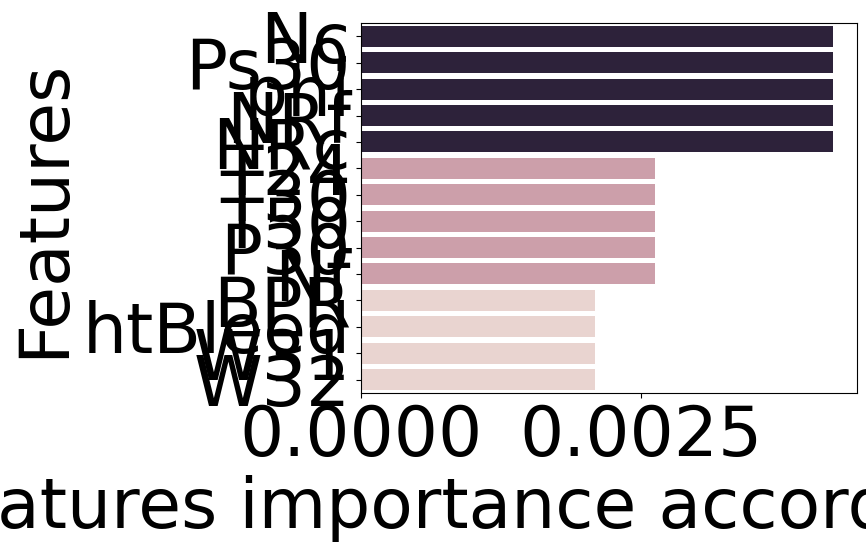

In [58]:
xi  = train_array[17:18]
e = KernelSHAP(model)
Shap_values = get_explainations(xi, e).values
explanations = {'KernelSHAP' : Shap_values[0]}

var_names = [str(rs)+'_'+str(i) for i in range(1,41) for rs in remaining_sensors]

# explainer_ = ['KernelSHAP', 'LIME', 'L2X']
idx = abs(explanations['KernelSHAP']).argsort()[-20:]

exp = explanations['KernelSHAP'][idx]
# var_names = np.array(var_names)[idx]
df_exp = pd.DataFrame({'idx' : idx, 'names' : np.array(var_names)[idx], 'feature_importance': exp})
df_sorted  = df_exp.sort_values('feature_importance', ascending = False)

exp_reshap = abs(Shap_values).reshape(xi.shape)
exp_reshap.shape

df_test = pd.DataFrame(exp_reshap[0])
df_test.columns = remaining_sensors
shap_unique = np.sum(abs(df_test), axis = 0)
shap_unique = shap_unique.sort_values(ascending=False)

sns.barplot(x=shap_unique.values, y = shap_unique.index, hue=shap_unique.values, legend=False)
plt.xlabel('Features importance according to SHAP')
plt.ylabel('Features')

# plt.savefig('results/top20_shap.png')
plt.show()

157/157 [==============================] - 4s 24ms/step


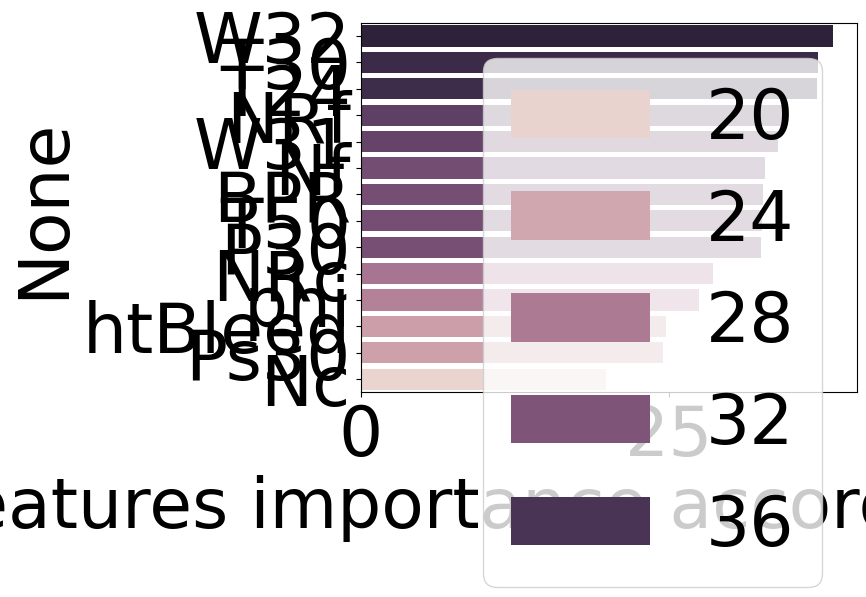

In [59]:
# Get lime feature importance
lime_explainer = RecurrentTabularExplainer(test_array, training_labels=label_array,
                                                       feature_names=remaining_sensors,
                                                       mode = 'regression',
                                                       )
lime_values = get_lime_explanation(xi, e = model.predict).values
explanations = {'Lime' : lime_values[0]}

# explainer_ = ['KernelSHAP', 'LIME', 'L2X']
idx = abs(explanations['Lime']).argsort()[-20:]

exp = explanations['Lime'][idx]
# var_names = np.array(var_names)[idx]
df_exp = pd.DataFrame({'idx' : idx, 'names' : np.array(var_names)[idx], 'feature_importance': abs(exp)})

df_exp['w_serted'] = abs(exp)
df_sorted = df_exp.sort_values('w_serted', ascending=False)

exp_reshap = lime_values.reshape(xi.shape)
exp_reshap.shape

df_test = pd.DataFrame(exp_reshap[0])
df_test.columns = remaining_sensors

lime_unique = np.sum(abs(df_test), axis = 0)
lime_unique = lime_unique.sort_values(ascending=False)
sns.barplot(x=lime_unique.values, y = lime_unique.index, hue=lime_unique.values)
plt.xlabel('Features importance according to LIME')
plt.show()

In [60]:
e = L2X(model.predict, xi)
Shap_values = get_explainations(xi, e, L2X = True).values

1/1 [==============================] - 1s 679ms/step - loss: 12741.7256 - mse: 12740.9688 - val_loss: 12761.1045 - val_mse: 12760.3682


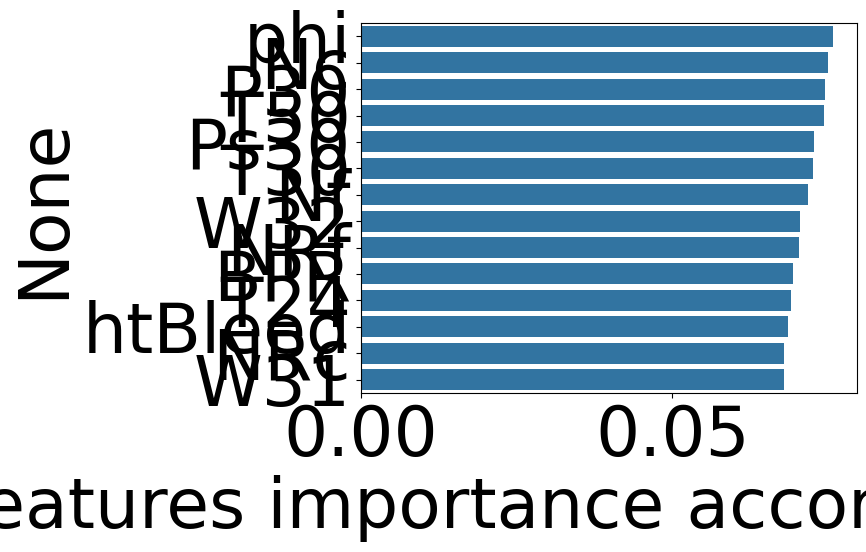

In [61]:
l2x_values = get_explainations(xi, e, L2X = True).values

# l2x_values = Shap_values
# explainer_ = ['KernelSHAP', 'LIME', 'L2X']
explanations = {'l2x' : l2x_values[0]}
idx = abs(explanations['l2x']).argsort()[-20:]

exp = explanations['l2x'][idx]
# var_names = np.array(var_names)[idx]
df_exp = pd.DataFrame({'idx' : idx, 'names' : np.array(var_names)[idx], 'feature_importance': exp})

df_exp['w_serted'] = abs(exp)
df_sorted = df_exp.sort_values('w_serted', ascending=False)

exp_reshap = l2x_values.reshape(xi.shape)
exp_reshap.shape

df_test = pd.DataFrame(exp_reshap[0])
df_test.columns = remaining_sensors

l2x_unique = np.sum(abs(df_test), axis = 0)
l2x_unique = l2x_unique.sort_values(ascending=False)
sns.barplot(x=l2x_unique.values, y = l2x_unique.index)
plt.xlabel('Features importance according to L2X')
plt.show()

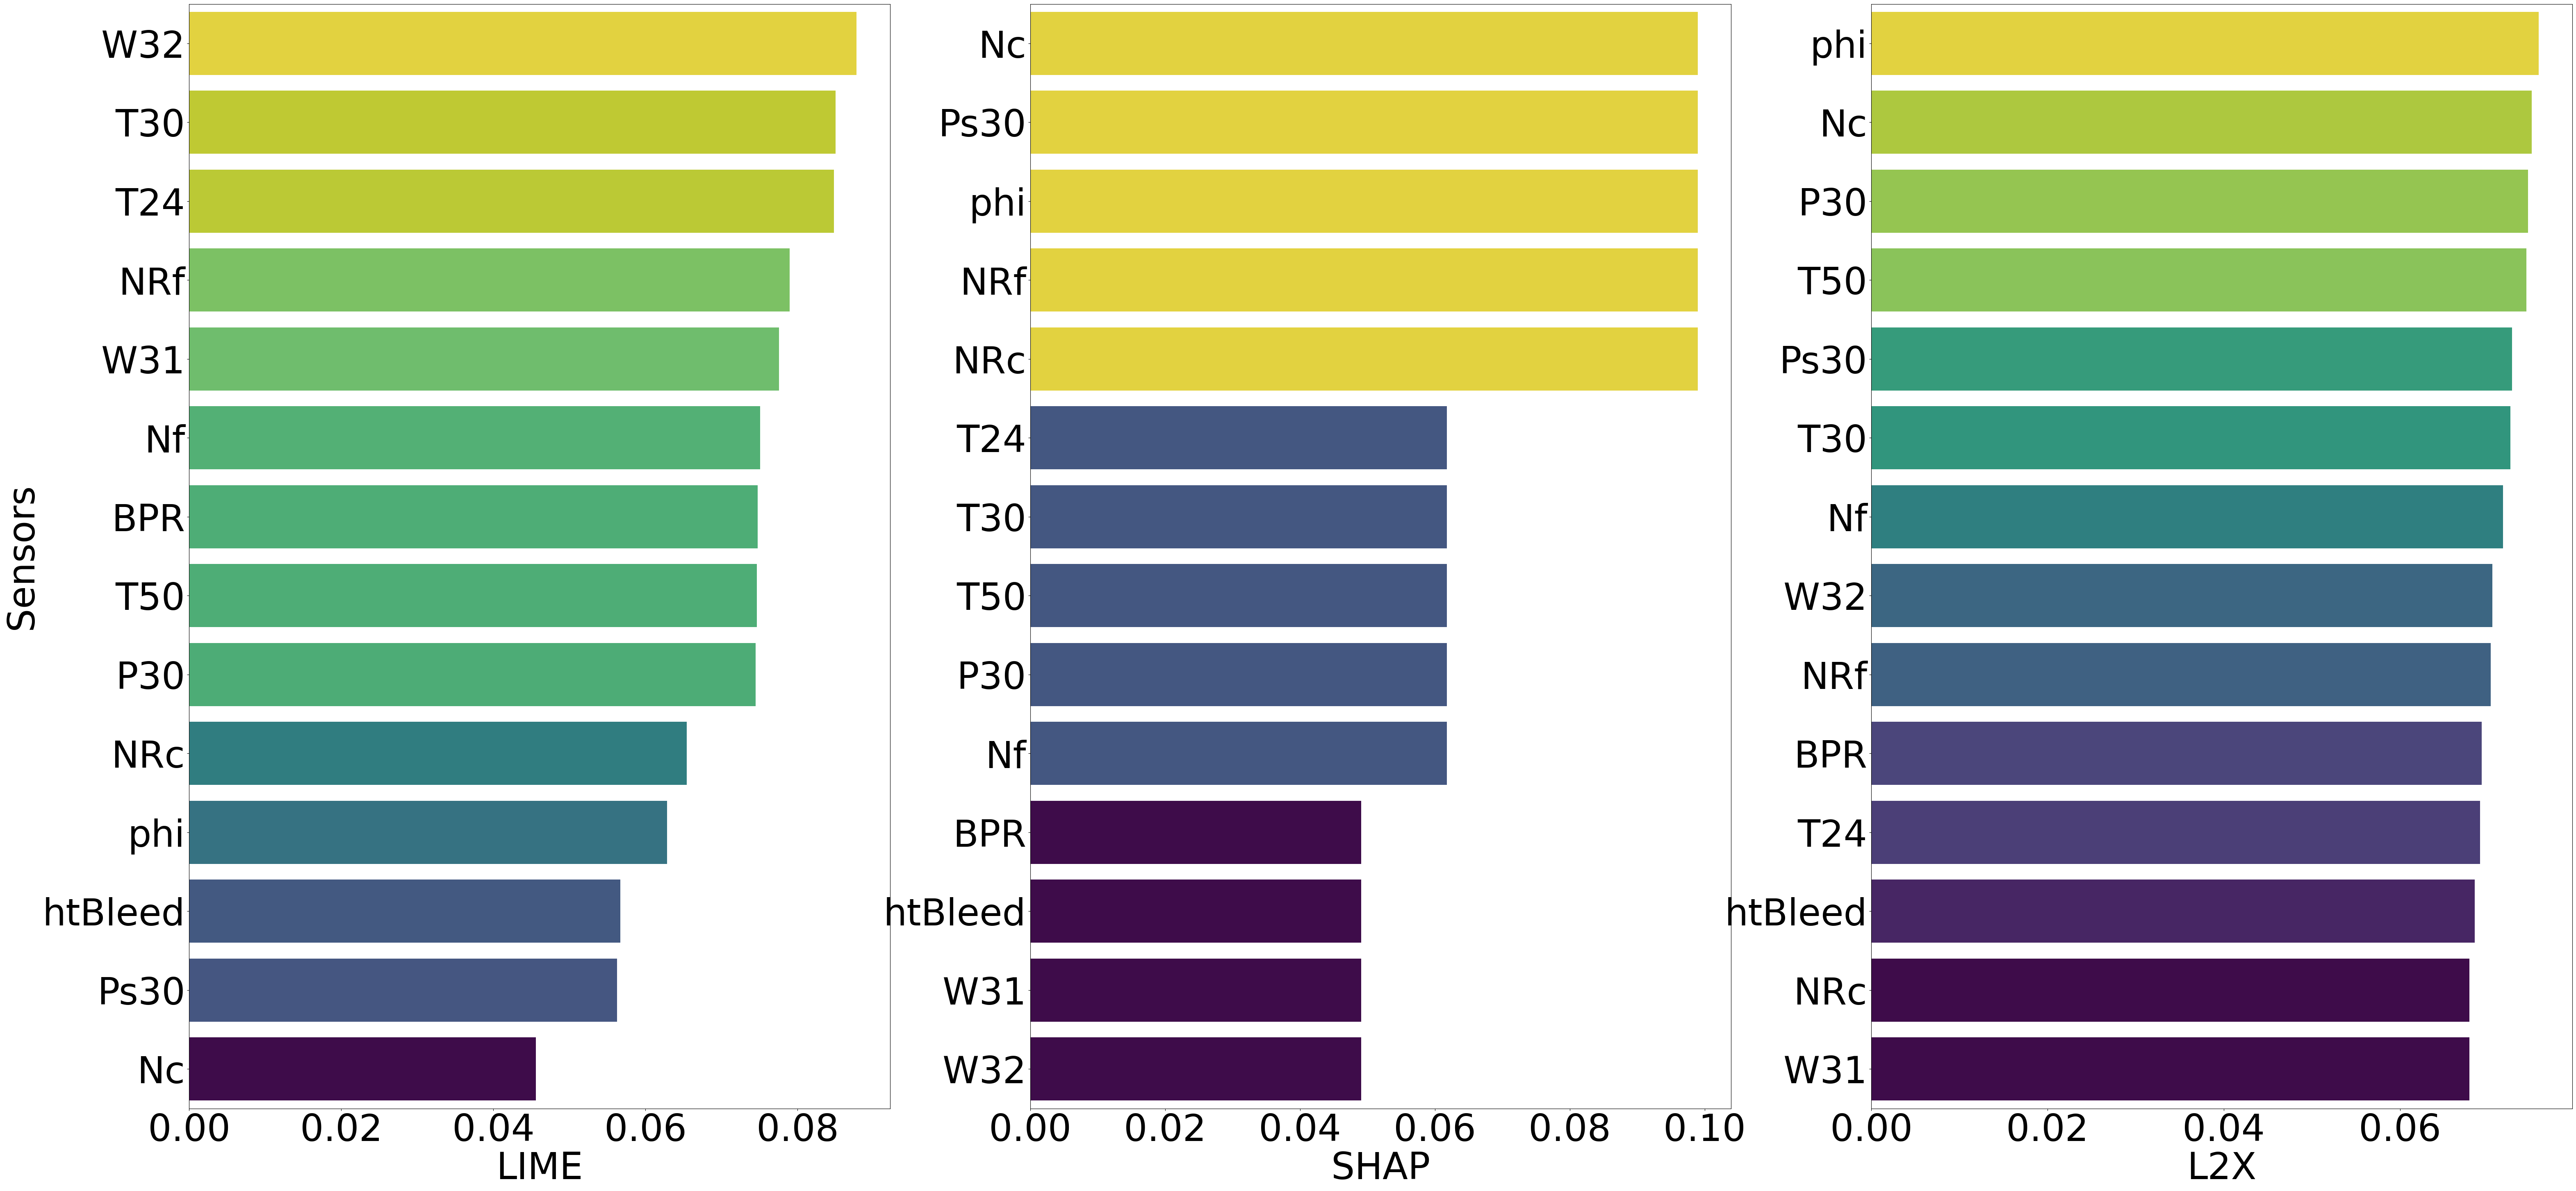

In [62]:
plt.rcParams.update({'font.size': 65})

plt.figure(figsize=(75,35))
plt.subplot(1,3,1)
sns.barplot(x=lime_unique.values/lime_unique.values.sum(), y = lime_unique.index, 
            hue=lime_unique.values/lime_unique.values.sum(), legend=False, palette='viridis')
plt.xlabel('LIME')
plt.ylabel('Sensors')

plt.subplot(1,3,2)
# plt.title("FD004")
sns.barplot(x=shap_unique.values/shap_unique.values.sum(), y = shap_unique.index, 
            hue=shap_unique.values/shap_unique.values.sum(), legend=False, palette='viridis')
plt.xlabel('SHAP')
plt.ylabel(None)

plt.subplot(1,3,3)
sns.barplot(x=l2x_unique.values, y = l2x_unique.index, hue=l2x_unique.values, legend=False, palette='viridis')
plt.xlabel('L2X')
plt.ylabel(None)
plt.savefig('explanations/fd004.png')
plt.show()

### Fd001

In [63]:
# Data preparation
# Data loading
train, test, y_test = prepare_data('FD001.txt')
print(train.shape, test.shape, y_test.shape)
# train['RUL'].clip(upper=125, inplace=True)
sensor_names = ['T20','T24','T30','T50','P20','P15','P30','Nf','Nc','epr','Ps30','phi',
                'NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

remaining_sensors = ['T24','T30','T50','P30','Nf','Nc','Ps30','phi',
                'NRf','NRc','BPR','htBleed','W31','W32'] # selection based on main_notebook

drop_sensors = [element for element in sensor_names if element not in remaining_sensors] 

(20631, 27) (13096, 26) (100, 1)


In [64]:
def model001(input_shape,weights_file, nb_layers = None):
    cb = keras.callbacks.EarlyStopping(monitor='loss', patience=4)
    if nb_layers==1:
        '''
        node = 256, activation = tanh, dropout = 0.3, bs = 64
        '''
    nodes_per_layer = 256
    activation_value= 'tanh'
    dropout = 0.3
    bs = 64

    model = Sequential()
    model.add(LSTM(nodes_per_layer, activation=activation_value, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(1))
        
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
    model.save_weights(weights_file)

    return model

In [65]:
# Data preparation
# Data prepration
sequence_length = 35
alpha = 0.5
upper = 120
    
learning_rate_ = 0.001
dropout = 0.3
activation = 'tanh'
epochs = 20
batch_size = 64
train = rul_piecewise_fct(train, upper)

X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)
# create sequences train, test
train_array = gen_data_wrapper(X_train_interim, sequence_length,remaining_sensors)
label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

test_gen = (list(gen_test_data(X_test_interim[X_test_interim['Unit']==unit_nr], sequence_length,remaining_sensors, -99.))
               for unit_nr in X_test_interim['Unit'].unique())
    
test_array = np.concatenate(list(test_gen)).astype(np.float32)
test_rul = rul_piecewise_fct(y_test,upper)
print(train_array.shape, label_array.shape, test_array.shape)


md = 5
if True:
    #Model creation
    weights_file = "fd001_result/" + str(md) + 'lstm_hyper_parameter_weights.h5'
    input_shape = (sequence_length, len(remaining_sensors))
    model = model001(input_shape=input_shape, weights_file=weights_file)
        
    mse_val = []
    R2_val = []
    RMSE = []
    score_val = []
    mse = []
    results = pd.DataFrame()
    # Model fitting
    with tf.device('/device:GPU:0'):
        history = model.fit(train_array, label_array,
                                validation_data=(test_array, test_rul),
                                epochs=epochs,
                                batch_size=batch_size,
                                # callbacks=[cb],
                                verbose=1)
        mse.append(history.history['val_loss'][-1])

        y_hat_val_split = model.predict(test_array)
        R2_val.append(r2_score(test_rul, y_hat_val_split))
        RMSE.append(np.sqrt(mean_squared_error(test_rul, y_hat_val_split)))
        score_val.append(compute_s_score(test_rul, y_hat_val_split))

        #  append results
    d = {'RMSE' :np.mean(RMSE), 'std_RMSE' :np.std(RMSE),
         'S_score' :np.mean(score_val), 'std_S_score' :np.std(score_val),
         'MSE':np.mean(mse), 'std_MSE':np.std(mse),
        #  'nodes':str(nodes_per_layer),
         'dropout':dropout, 'activation':activation, 'batch_size':batch_size,
         'TW' : sequence_length, 'alpha' : alpha, 'upper' : upper}
    results = pd.concat([results, pd.DataFrame(d, index=[0])], ignore_index=True)

(17231, 35, 14) (17231, 1) (100, 35, 14)
Epoch 1/20
270/270 [==============================] - 11s 36ms/step - loss: 2979.8538 - val_loss: 1598.1678
Epoch 2/20
270/270 [==============================] - 9s 35ms/step - loss: 1649.3622 - val_loss: 1557.5767
Epoch 3/20
270/270 [==============================] - 9s 35ms/step - loss: 1626.1165 - val_loss: 1563.1144
Epoch 4/20
270/270 [==============================] - 10s 36ms/step - loss: 1624.4447 - val_loss: 1558.9087
Epoch 5/20
270/270 [==============================] - 9s 35ms/step - loss: 1625.7817 - val_loss: 1558.5519
Epoch 6/20
270/270 [==============================] - 9s 35ms/step - loss: 1624.5660 - val_loss: 1546.8823
Epoch 7/20
270/270 [==============================] - 9s 35ms/step - loss: 1481.4774 - val_loss: 860.5128
Epoch 8/20
270/270 [==============================] - 9s 35ms/step - loss: 578.1475 - val_loss: 530.0535
Epoch 9/20
270/270 [==============================] - 9s 35ms/step - loss: 315.3347 - val_loss: 254.9655

8/8 [==============================] - 0s 20ms/step


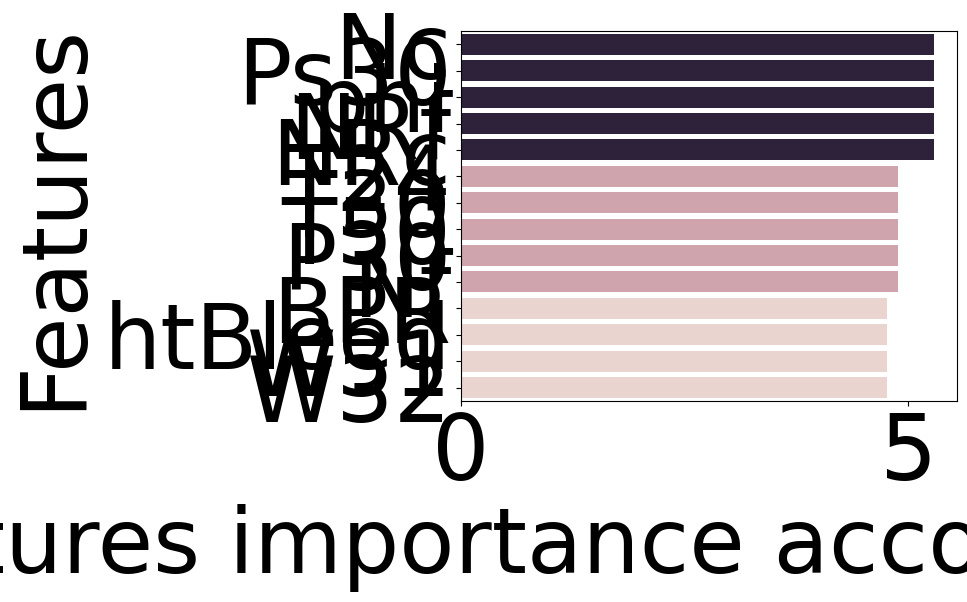

In [66]:
xi  = train_array[17:18]
e = KernelSHAP(model)
Shap_values = get_explainations(xi, e).values
explanations = {'KernelSHAP' : Shap_values[0]}

var_names = [str(rs)+'_'+str(i) for i in range(1,41) for rs in remaining_sensors]

# explainer_ = ['KernelSHAP', 'LIME', 'L2X']
idx = abs(explanations['KernelSHAP']).argsort()[-20:]

exp = explanations['KernelSHAP'][idx]
# var_names = np.array(var_names)[idx]
df_exp = pd.DataFrame({'idx' : idx, 'names' : np.array(var_names)[idx], 'feature_importance': exp})
df_sorted  = df_exp.sort_values('feature_importance', ascending = False)

exp_reshap = abs(Shap_values).reshape(xi.shape)
exp_reshap.shape

df_test = pd.DataFrame(exp_reshap[0])
df_test.columns = remaining_sensors
shap_unique = np.sum(abs(df_test), axis = 0)
shap_unique = shap_unique.sort_values(ascending=False)

sns.barplot(x=shap_unique.values, y = shap_unique.index, hue=shap_unique.values, legend=False)
plt.xlabel('Features importance according to SHAP')
plt.ylabel('Features')

# plt.savefig('results/top20_shap.png')
plt.show()

157/157 [==============================] - 2s 11ms/step


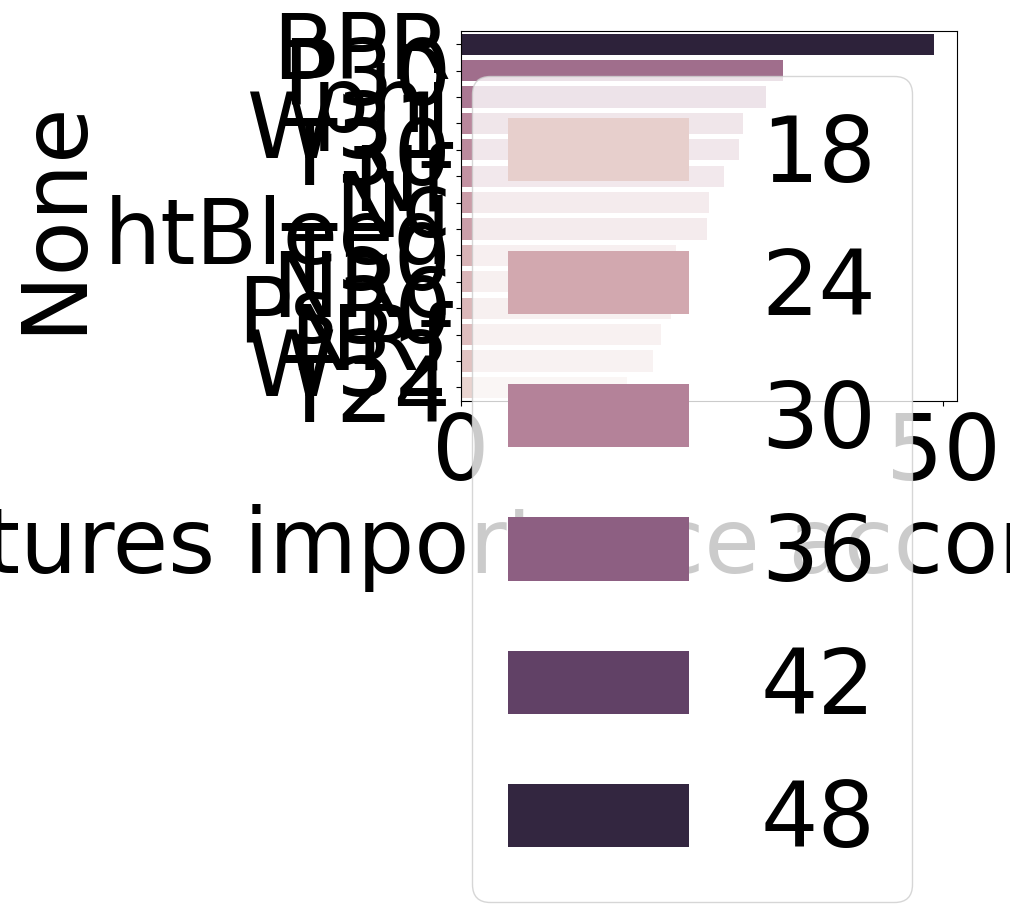

In [67]:
# Get lime feature importance
lime_explainer = RecurrentTabularExplainer(test_array, training_labels=label_array,
                                                       feature_names=remaining_sensors,
                                                       mode = 'regression',
                                                       )
lime_values = get_lime_explanation(xi, e = model.predict).values
explanations = {'Lime' : lime_values[0]}

# explainer_ = ['KernelSHAP', 'LIME', 'L2X']
idx = abs(explanations['Lime']).argsort()[-20:]

exp = explanations['Lime'][idx]
# var_names = np.array(var_names)[idx]
df_exp = pd.DataFrame({'idx' : idx, 'names' : np.array(var_names)[idx], 'feature_importance': abs(exp)})

df_exp['w_serted'] = abs(exp)
df_sorted = df_exp.sort_values('w_serted', ascending=False)

exp_reshap = lime_values.reshape(xi.shape)
exp_reshap.shape

df_test = pd.DataFrame(exp_reshap[0])
df_test.columns = remaining_sensors

lime_unique = np.sum(abs(df_test), axis = 0)
lime_unique = lime_unique.sort_values(ascending=False)
sns.barplot(x=lime_unique.values, y = lime_unique.index, hue=lime_unique.values)
plt.xlabel('Features importance according to LIME')
plt.show()

In [68]:
e = L2X(model.predict, xi)
Shap_values = get_explainations(xi, e, L2X = True).values

1/1 [==============================] - 1s 739ms/step - loss: 13245.6660 - mse: 13244.9131 - val_loss: 13219.9219 - val_mse: 13219.1885


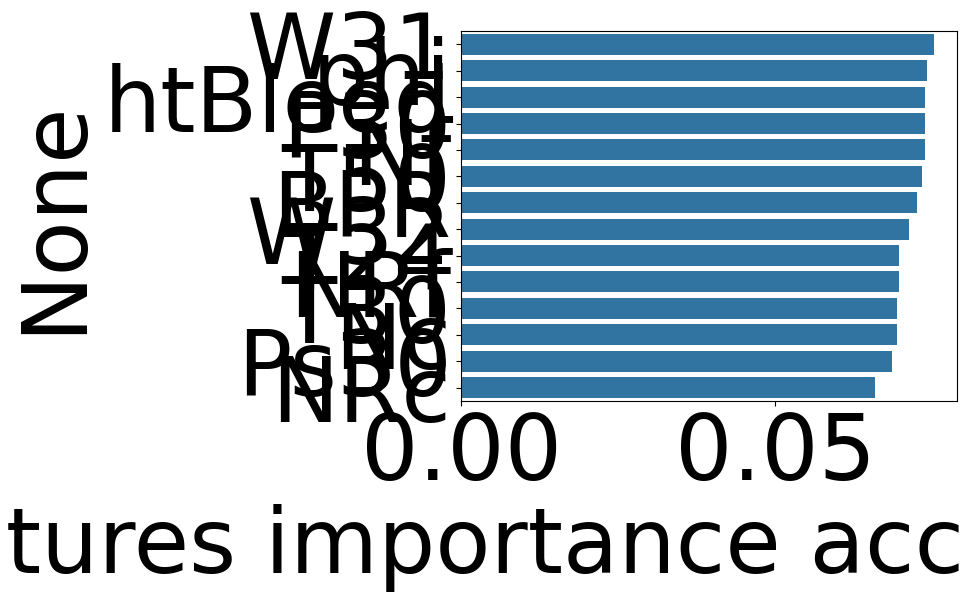

In [69]:
l2x_values = get_explainations(xi, e, L2X = True).values

# l2x_values = Shap_values
# explainer_ = ['KernelSHAP', 'LIME', 'L2X']
explanations = {'l2x' : l2x_values[0]}
idx = abs(explanations['l2x']).argsort()[-20:]

exp = explanations['l2x'][idx]
# var_names = np.array(var_names)[idx]
df_exp = pd.DataFrame({'idx' : idx, 'names' : np.array(var_names)[idx], 'feature_importance': exp})

df_exp['w_serted'] = abs(exp)
df_sorted = df_exp.sort_values('w_serted', ascending=False)

exp_reshap = l2x_values.reshape(xi.shape)
exp_reshap.shape

df_test = pd.DataFrame(exp_reshap[0])
df_test.columns = remaining_sensors

l2x_unique = np.sum(abs(df_test), axis = 0)
l2x_unique = l2x_unique.sort_values(ascending=False)
sns.barplot(x=l2x_unique.values, y = l2x_unique.index)
plt.xlabel('Features importance according to L2X')
plt.show()

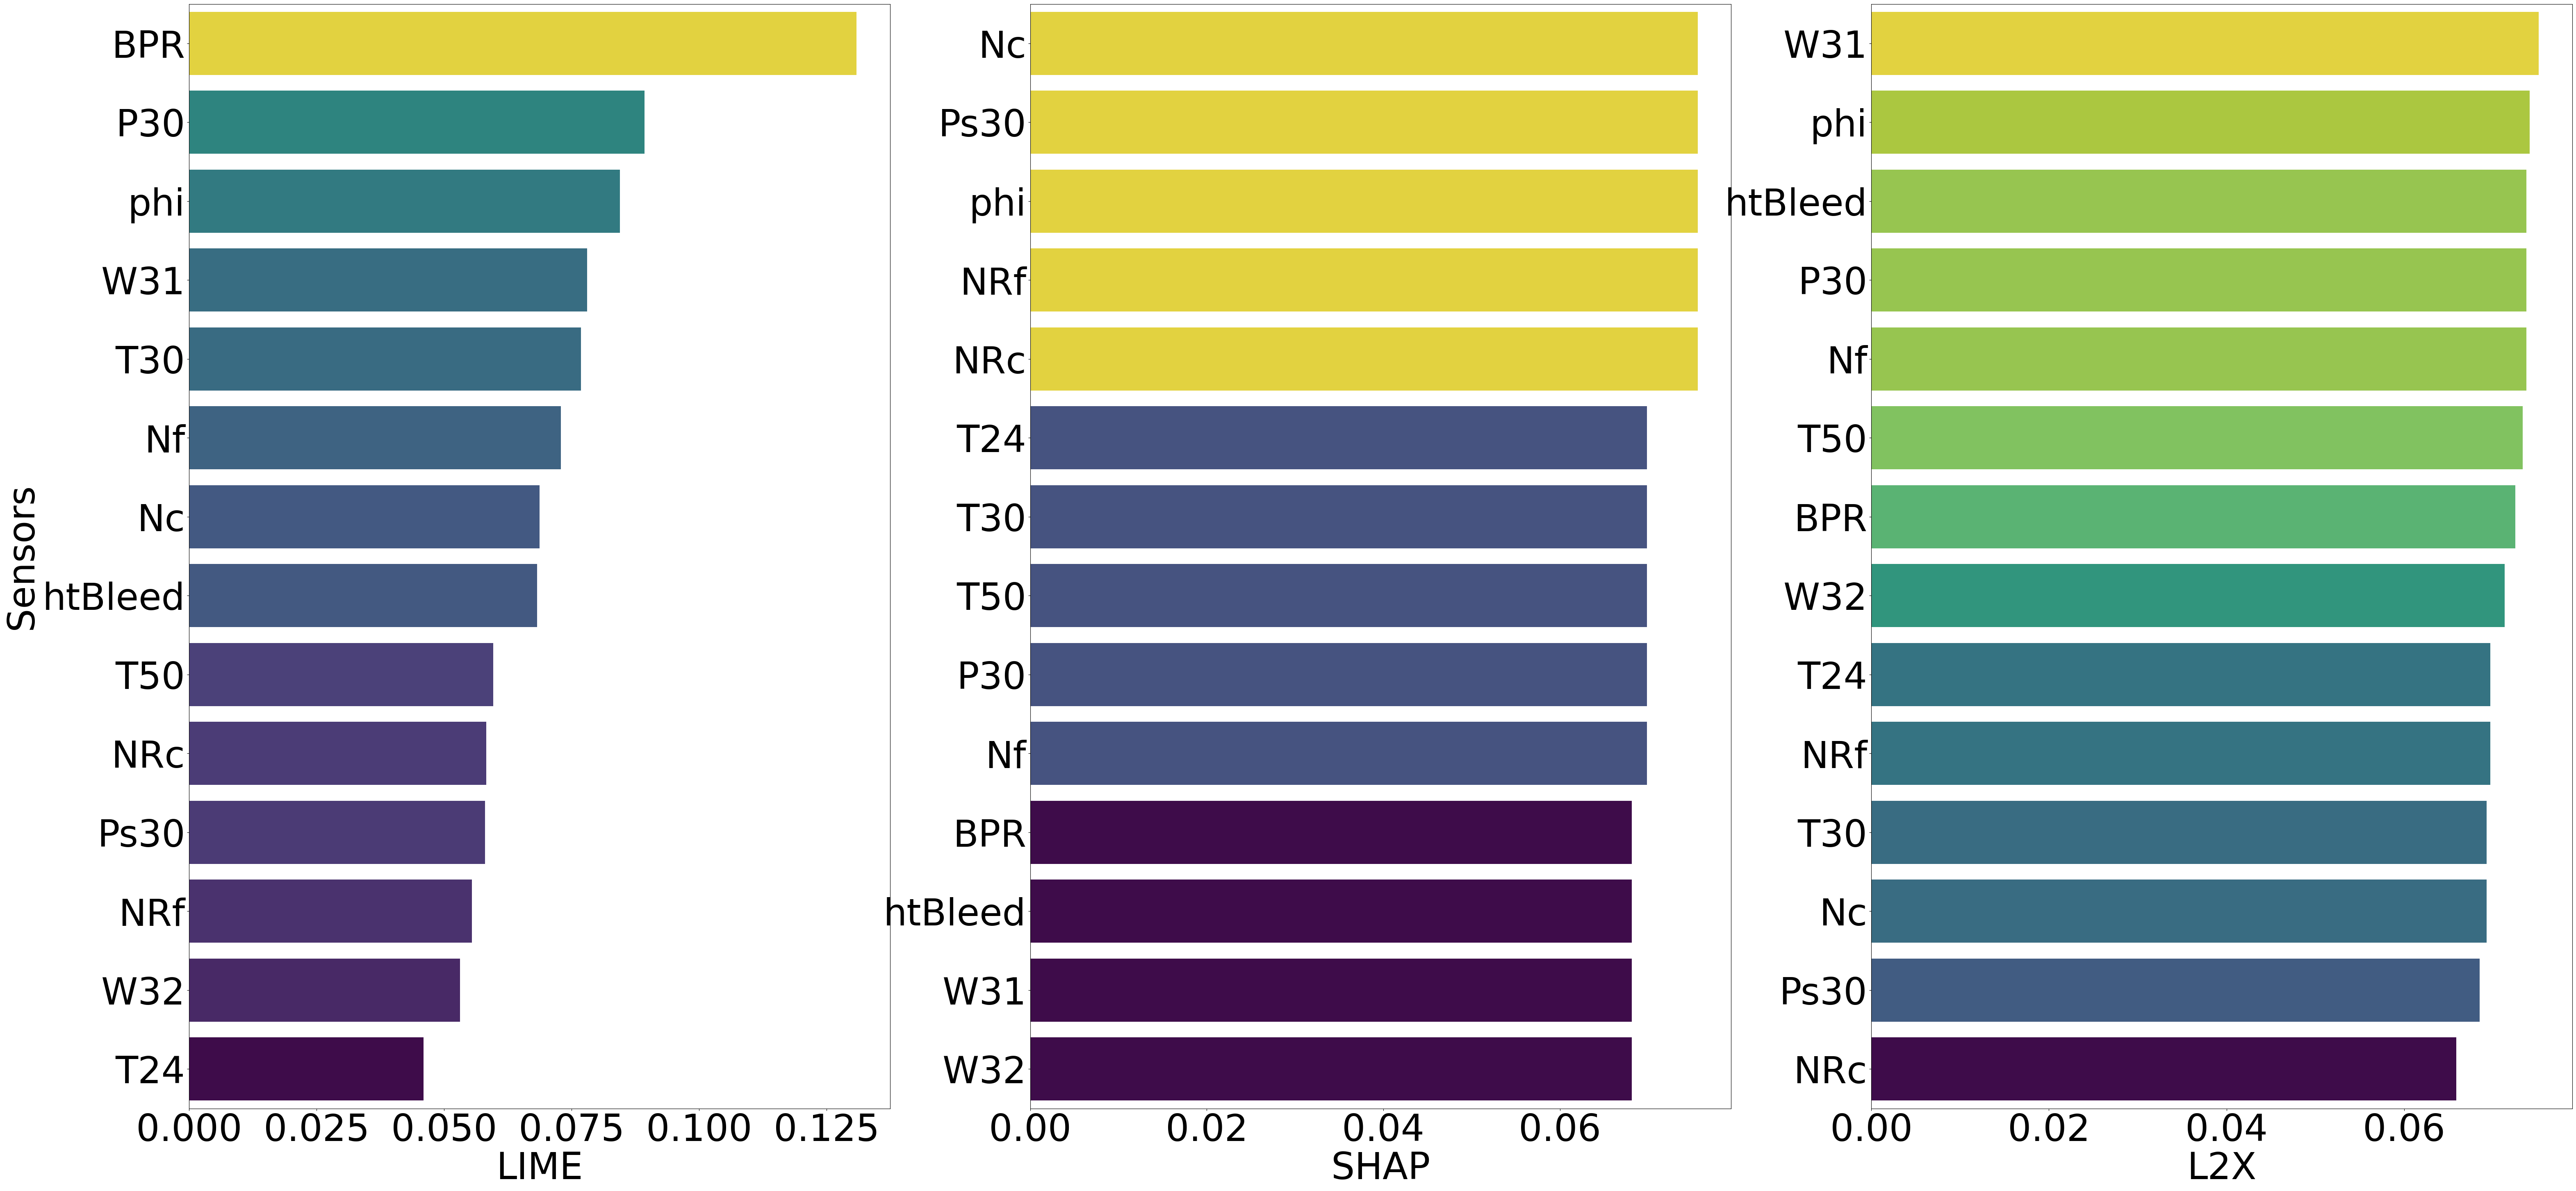

In [72]:
plt.rcParams.update({'font.size': 65})

plt.figure(figsize=(75,35))
plt.subplot(1,3,1)
sns.barplot(x=lime_unique.values/lime_unique.values.sum(), y = lime_unique.index, 
            hue=lime_unique.values/lime_unique.values.sum(), legend=False, palette='viridis')
plt.xlabel('LIME')
plt.ylabel('Sensors')

plt.subplot(1,3,2)
# plt.title("FD001")
sns.barplot(x=shap_unique.values/shap_unique.values.sum(), y = shap_unique.index, 
            hue=shap_unique.values/shap_unique.values.sum(), legend=False, palette='viridis')
plt.xlabel('SHAP')
plt.ylabel(None)

plt.subplot(1,3,3)
sns.barplot(x=l2x_unique.values, y = l2x_unique.index, hue=l2x_unique.values, legend=False, palette='viridis')
plt.xlabel('L2X')
plt.ylabel(None)
plt.savefig('explanations/fd001.png')
plt.show()

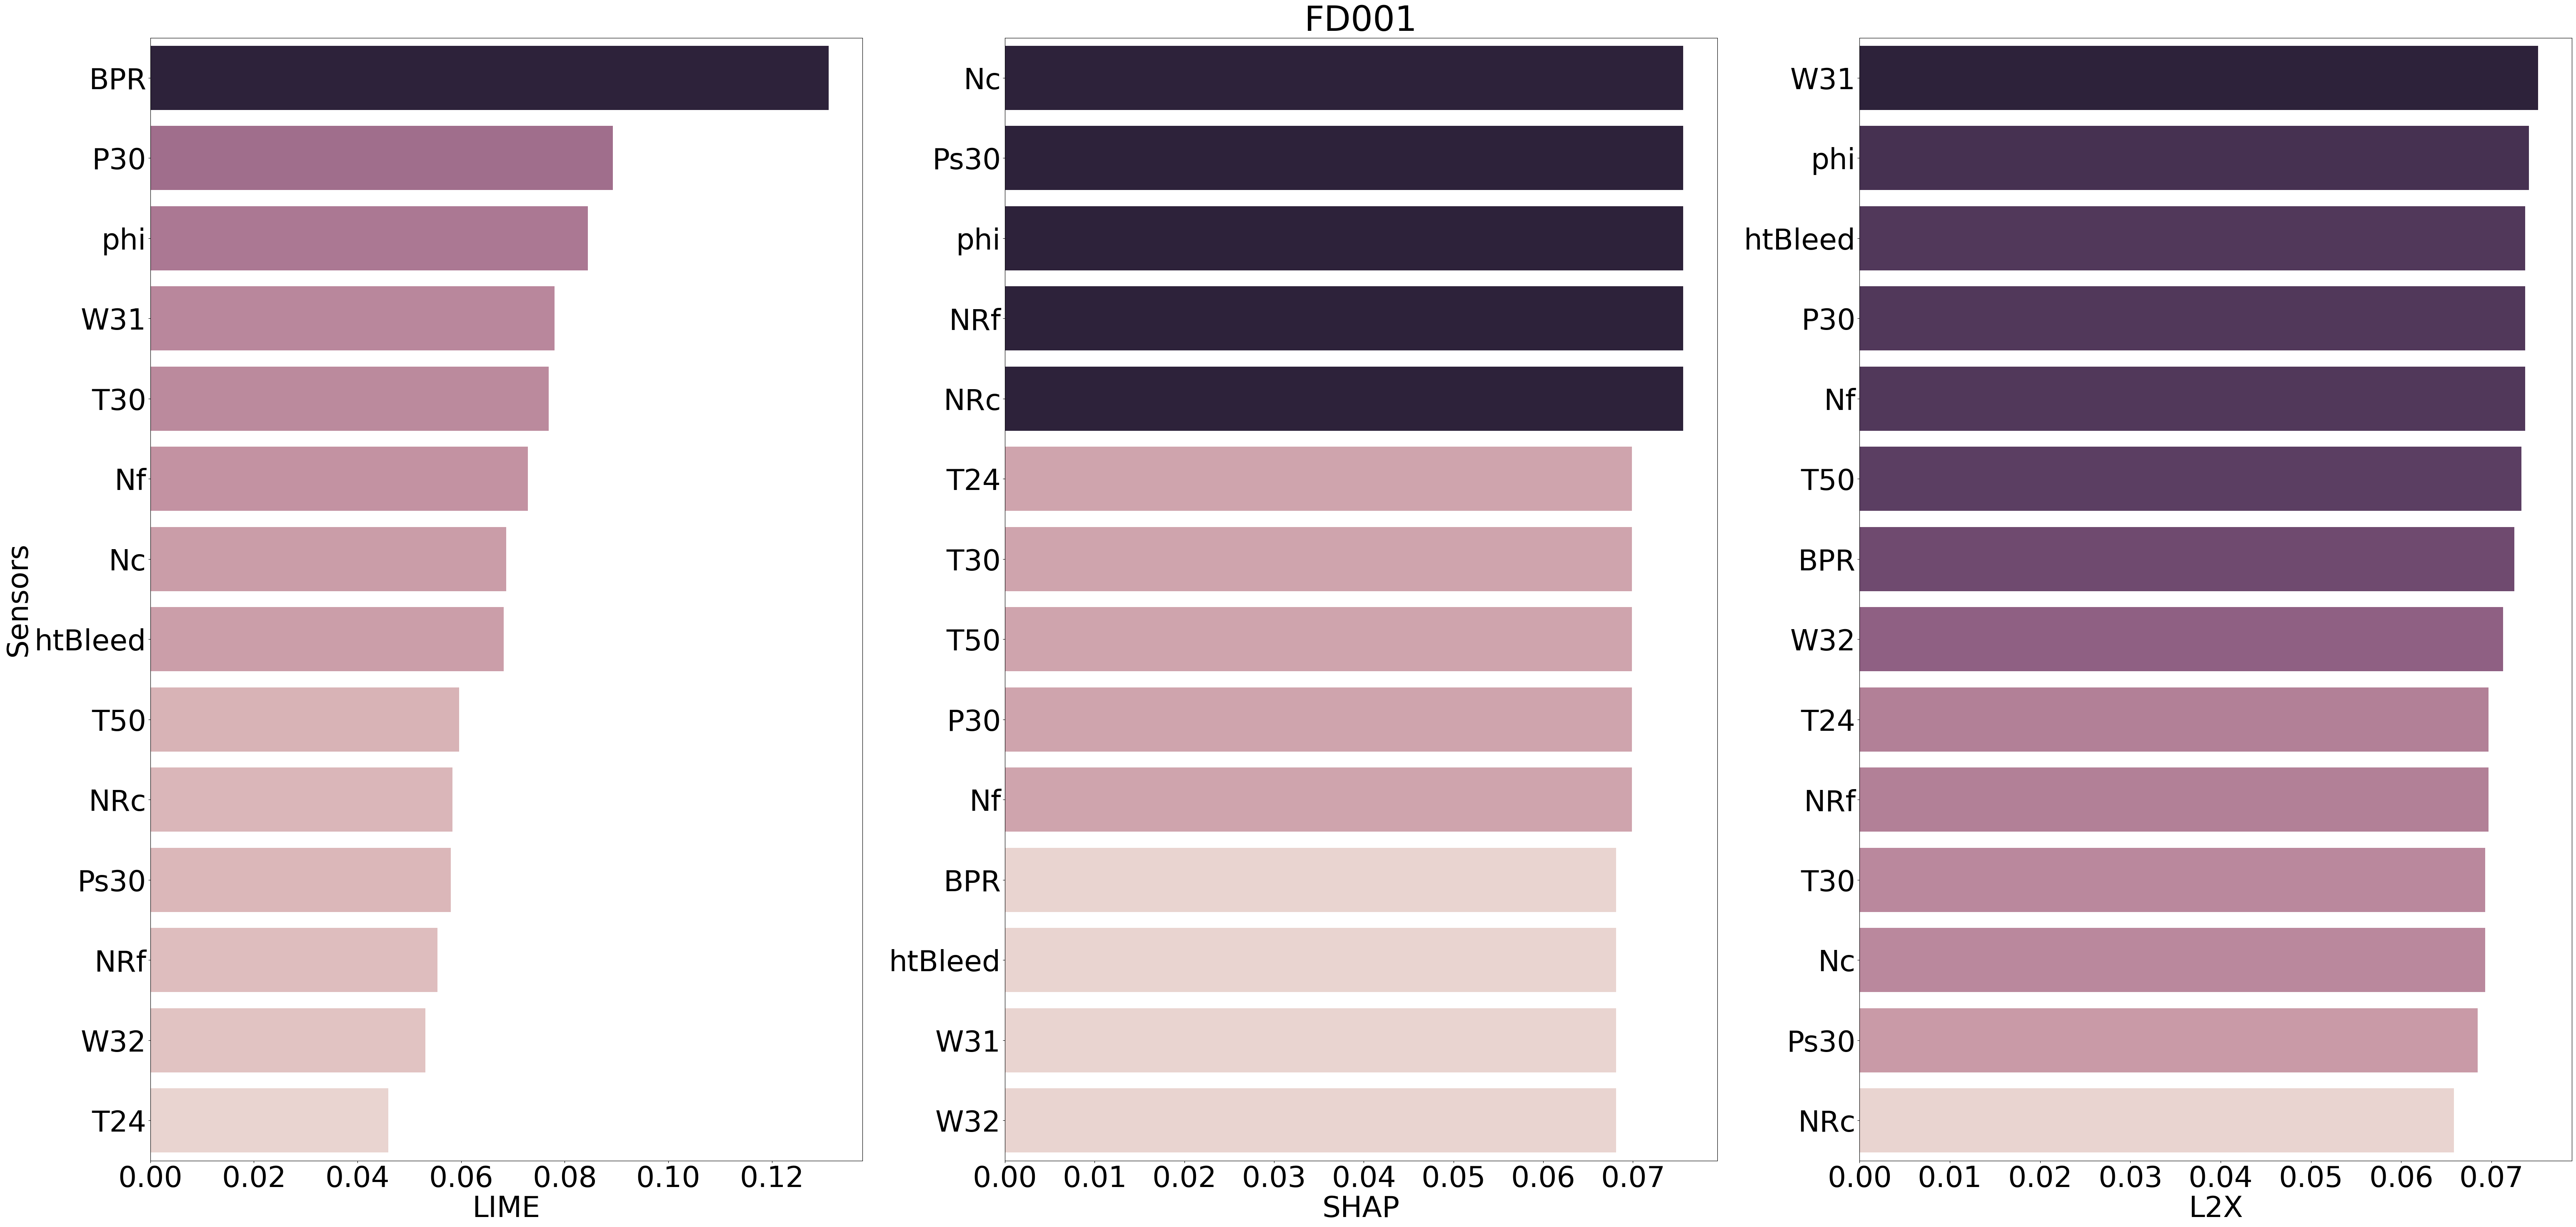

In [71]:
plt.rcParams.update({'font.size': 50})

plt.figure(figsize=(75,35))
plt.subplot(1,3,1)
sns.barplot(x=lime_unique.values/lime_unique.values.sum(), y = lime_unique.index, 
            hue=lime_unique.values/lime_unique.values.sum(), legend=False)
plt.xlabel('LIME')
plt.ylabel('Sensors')

plt.subplot(1,3,2)
plt.title("FD001")
sns.barplot(x=shap_unique.values/shap_unique.values.sum(), y = shap_unique.index, 
            hue=shap_unique.values/shap_unique.values.sum(), legend=False)
plt.xlabel('SHAP')
plt.ylabel(None)

plt.subplot(1,3,3)
sns.barplot(x=l2x_unique.values, y = l2x_unique.index, hue=l2x_unique.values, legend=False)
plt.xlabel('L2X')
plt.ylabel(None)
plt.savefig('explanations/fd001.png')
plt.show()